# INITIALIZATION

## Definitions (imports & functions)

In [11]:
# Monitoring
print("\n>> Definitions:")

# ---------------------------------- MODULES -----------------------------------

# Essential
import numpy as np
import pandas as pd

# System
import sys
import os

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, \
                            classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, \
                                    BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet, vgg16, xception
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, \
                                       ReduceLROnPlateau, EarlyStopping

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Additionnal
from tqdm import tqdm # see: https://github.com/tqdm/tqdm#readme
import joblib
import datetime


# Monitoring
print("Modules importation successful")

# --------------------------------- FUNCTIONS ----------------------------------


def add_images_paths(df, images_folder, pathcol='img_path', savepath=None):
    """
    Fetches paths of all filenames in specified folder and copies them in a
    specified new column, at relevant rows, of given DataFrame.
    Optionally saves the resulting DataFrame to specified path.
    """
    # Checks
    assert ('imageid' in df), "DataFrame must have 'imageid' column"
    # Check if column is already filled
    if pathcol not in df:
        # Create new column
        df[pathcol] = np.nan
        # For all image files in directory
        filenames = os.listdir(images_folder)
        for name in filenames:
            fullpath = images_folder + '/' + name
            imageid = int(name.split('_')[1]) # Extract imageid from filename
            try: # Check files are valid
                plt.imread(fullpath)
            except:
                print(f"Image '{imageid}' cannot be read and will be removed")
            else:
                # Save path in matching row of dataset
                df.loc[df['imageid'] == imageid, pathcol] = fullpath
        print(f"Valid images paths have been added to column '{pathcol}'")
        # Drop observations with missing images
        idxs_del = df[pathcol].isna()
        if idxs_del.any():
            print("The following observations will be deleted:")
            display(df[idxs_del])
            df = df[- idxs_del]
        if savepath:
            # Save modified dataset
            df.to_csv(savepath, index=True)
            print(f"Dataframe saved to: '{savepath}'")
    else:
        print("Images paths are already filled")
    return df




def create_balanced_subset(df, samples_per_class, targetcol='target', savepath=None):
    """
    Extracts a balanced subset from given DataFrame by random downsampling each
    class to fixed specified number of observations
    """
    # Check
    condition = samples_per_class < df[targetcol].value_counts().min()
    error_msg = f"Number {samples_per_class} exceeds cardinal of smallest class"
    assert condition, error_msg
    # Go through all modalities
    idxs = [] # list of indexes to select
    for label in list(df[targetcol].unique()):
        # Indexes matching label
        idxs_label = list(df[df['target'] == label].index)
        # Sample random specimens
        np.random.shuffle(idxs_label)
        idxs_rand = idxs_label[:samples_per_class]
        # Add to list
        idxs += idxs_rand
    # Extract rows
    df = df.loc[df.index.intersection(idxs)]
    print("Balanced subset successfully created")
    if savepath:
        # Save subset
        df.to_csv(savepath, index=True, header=True)
        print(f"Dataframe saved to: '{savepath}'")
    return df




def show_dataframe_info(df, targetcol='target'):
    """
    Prints basic information about given DataFrame and displays its first rows.
    """
    # Checks
    assert (targetcol in df), f"DataFrame must have '{targetcol}' column"
    # Display info
    print("Number of observations:\n", len(df))
    print("Number of observations by class:\n",
            df[targetcol].value_counts().sort_index().to_dict())
    print("Extract of dataframe:\n")
    display(df.head())




def show_model_info(model, compiled=True):
    """
    Displays model summary and prints additional information.
    """
    print("MODEL INFO:")
    print("\n", model.summary(), "\n")
    print("Number of layers:", len(model.layers))
    if compiled:
        print("Optimizer:", model.optimizer.__class__.__name__)
        print("Learning rate:", model.optimizer.learning_rate.numpy())
        print("Loss function:", model.loss)
        print("Metrics (training):", model.metrics_names)



def show_weights(model, layer_idx):
    """
    Prints weights of specified layer in given model.
    This was used for debugging purposes.
    """
    layer = model.layers[layer_idx]
    wgts = layer.get_weights()[0] # index 0 are weights ; index 1 are biases
    print(f"Weights (bias excluded) of layer '{layer.name}':\n {wgts}")



def check_images(df, pathcol='img_path'):
    """
    Checks that paths in given DataFrame point to valid images.
    """
    # For each path in dataframe
    for path in tqdm(df[pathcol]):
        try:
            plt.imread(path)    # try to read file as RGB(A) PNG image
        except:
            # Extract metadata from path
            filename = path.split('/')[-1].split('.')[0]  # get filename (no extension)
            imageid = int(filename.split('_')[1])         # get imageid from filename
            productid = int(filename.split('_')[3])       # get productid from filename
            # Warn and drop
            print(f"Image '{imageid}' cannot be read and will be removed")
            df = df.drop(index=productid) # remove index of faulty image
    return df



def history_load(path, verbose=0):
    """
    Load training history from file depending on extension.
    Output is encoded as Pandas DataFrame.
    Only joblib and CSV format are supported.
    """
    # Extract metadata from path
    extension = path.split('.')[-1]                     # get file extension
    modelname = ((path.split('.')[-2]).split('/'))[-1]  # get model name
    # Load file
    if extension == 'jl':       # joblib format (used in earlier versions)
        hist = pd.DataFrame.from_dict(joblib.load(path))
        if verbose > 0:
            print("Found file in Joblib format") # DEBUG
    elif extension == 'csv':    # CSV format (used in latest versions)
        hist = pd.read_csv(path, header=0)
        if verbose > 0:
            print("Found file in CSV format") # DEBUG
    else:
        raise ValueError("unknown history format")
    if 'model' not in hist:
        hist['model'] = modelname   # add model name to history
    return hist


def complexity_graph(hist):
    """
    Plot complexity graph (loss & metrics of train data vs validation data) from
    history (encoded as Pandas DataFrame).
    """
    ticks = range(1, len(hist['loss'])+1)  # epochs (starting from 1)
    plt.figure(figsize=(20, 6))
    if 'model' in hist:
        plt.suptitle(hist['model'][0], fontsize=20)
    plt.subplot(121)
    plt.title('Model loss vs epoch', fontsize=16)
    plt.plot(ticks, hist['loss'], '-+', label='training')
    plt.plot(ticks, hist['val_loss'], '-+', label='validation')
    plt.xlabel('Epoch', fontsize=14)
    plt.xticks(ticks)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.subplot(122)
    plt.title('Model accuracy vs epoch', fontsize=16)
    plt.plot(ticks, hist['accuracy'], '-+', label='training')
    plt.plot(ticks, hist['val_accuracy'], '-+', label='validation')
    plt.xlabel('Epoch', fontsize=14)
    plt.xticks(ticks)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show();



class GeneratorMetrics(Callback):
    """
    Computes precision, recall & F1-score on epoch end.
    Rationale: computing them batch-wise is wrong.
    Original: https://gist.github.com/rragundez/ae3a17428bfec631d1b35dcdc6296a85
    Adapted for TF.Keras 2.0 and use of ImageDataGenerator.
    """

    def __init__(self, validation_generator, average='weighted'):
        self.validation_generator = validation_generator
        self.validation_steps = len(validation_generator)
        self.average = average

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # Extract predictions & labels (modified)
        y_probs = model.predict(self.validation_generator)
        y_pred = np.argmax(y_probs, axis=1) # decision
        y_true = np.array(self.validation_generator.classes)
        # Compute scores
        _val_f1 = f1_score(y_true, y_pred, average=self.average)
        _val_recall = recall_score(y_true, y_pred, average=self.average)
        _val_precision = precision_score(y_true, y_pred, average=self.average)
        # Save
        self.val_f1_scores.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        # Print
        print((f"val_f1_score: {_val_f1:.5f}"
            + f" - val_precision: {_val_precision:.5f}"
            + f" - val_recall: {_val_recall:.5f}"))


# Monitoring
print("Functions definitions successful")


>> Definitions:
Modules importation successful
Functions definitions successful


## Configuration (edit if needed)

### Paths configuration

In [12]:
# Set paths
PATH_IMG_TRAIN = "../images/image_train"
PATH_WORK = "./"

# Go to work directory
os.chdir(PATH_WORK)
print(f"\n>> Content of current directory:\n {os.listdir()}")


>> Content of current directory:
 ['.git', '.gitignore', '.ipynb_checkpoints', 'classification_images.ipynb', 'classification_images_local.ipynb', 'class_index_decoding.csv', 'data_exploration.ipynb', 'data_train_cv.csv', 'data_viz_image.ipynb', 'fullset1.csv', 'imgtools.py', 'labels_encoding.csv', 'LICENSE', 'mean_images.pkl', 'models', 'nbimages', 'prdtype_decode.csv', 'README.md', 'streamlit', 'subset1.csv', 'trainset.csv', 'var_images.pkl', '__pycache__']


### Options configuration

In [13]:
# Monitoring
print("\n>> Options:")

# --------------------------------- PARAMETERS ---------------------------------

TF_GLOBAL_SEED = 666    # Tensorflow global seed (set for reproductibility)

# --------------------------------- EXECUTION ----------------------------------

tf.random.set_seed(TF_GLOBAL_SEED) # Tensorflow global seed (set for reproductibility)
print(f"Tensorflow global seed was set to: {TF_GLOBAL_SEED}")
# NB: This was used only for this last model.


>> Options:
Tensorflow global seed was set to: 666


# DATA

## Loading & processing

In [14]:
# --------------------------------- PARAMETERS ---------------------------------

# Columns names
PATHS_COL = 'img_path'  # column containing paths to images
LABELS_COL = 'target'   # column containing target labels

# Select dataset
PATH_DATA_TRAIN = "data_train_cv.csv" # /!\ relative path to dataset /!\

# Processing
DOWNSAMPLE = False                    # toggle to downsample
SAMPLES_PER_CLASS = 750               # should be smaller than smallest cardinal
PATH_DATA_SAVE = "data_train_cv.csv"  # path for processed DataFrame to be saved

# --------------------------------- EXECUTION ----------------------------------

# Load dataset
data = pd.read_csv(
              filepath_or_buffer = PATH_DATA_TRAIN,   # path to CSV data
              header = 0,                            
              index_col = 'productid'
              )
print("\n>> Original DataFrame information:")
show_dataframe_info(data) # show original dataset

# PROCESSING
print("\n>> Processing DataFrame...")
# Drop text-related columns (if needed)
if 'designation' in data:
    data = data.drop(columns=['designation'])
if 'description' in data:
    data = data.drop(columns=['description'])
# Create balanced subset (if asked to)
if DOWNSAMPLE:
    data = create_balanced_subset(
                df = data,                              # the Pandas DataFrame to process
                samples_per_class = SAMPLES_PER_CLASS,  # downsample to that number
                targetcol = LABELS_COL,                 # column containing target labels
                savepath = PATH_DATA_SAVE               # path for processed DataFrame to be saved
                )
# Add images paths (if needed)
data = add_images_paths(
          df = data,                        # the Pandas DataFrame to process
          images_folder = PATH_IMG_TRAIN,   # path to images folder
          pathcol = PATHS_COL,              # pame of column to write paths to
          savepath = PATH_DATA_SAVE         # path for processed DataFrame to be saved
          )
# Get some information
N_OBS = len(data)
N_CLASS = len(data[LABELS_COL].unique())
# Show final dataset
print("DataFrame was successfully processed")
print("\n>> Processed DataFrame information:")
show_dataframe_info(data)


>> Original DataFrame information:
Number of observations:
 84916
Number of observations by class:
 {0: 3116, 1: 4760, 2: 1681, 3: 4870, 4: 2761, 5: 4989, 6: 2589, 7: 5073, 8: 2070, 9: 4303, 10: 4774, 11: 2671, 12: 10209, 13: 764, 14: 5045, 15: 1421, 16: 3953, 17: 4993, 18: 2508, 19: 832, 20: 3241, 21: 2491, 22: 824, 23: 872, 24: 2496, 25: 803, 26: 807}
Extract of dataframe:



,imageid,target,img_path
productid,,,
3804725264,1263597046,0,../images/image_train/image_1263597046_product...
436067568,1008141237,1,../images/image_train/image_1008141237_product...
201115110,938777978,2,../images/image_train/image_938777978_product_...
50418756,457047496,3,../images/image_train/image_457047496_product_...
278535884,1077757786,4,../images/image_train/image_1077757786_product...



>> Processing DataFrame...
Images paths are already filled
DataFrame was successfully processed

>> Processed DataFrame information:
Number of observations:
 84916
Number of observations by class:
 {0: 3116, 1: 4760, 2: 1681, 3: 4870, 4: 2761, 5: 4989, 6: 2589, 7: 5073, 8: 2070, 9: 4303, 10: 4774, 11: 2671, 12: 10209, 13: 764, 14: 5045, 15: 1421, 16: 3953, 17: 4993, 18: 2508, 19: 832, 20: 3241, 21: 2491, 22: 824, 23: 872, 24: 2496, 25: 803, 26: 807}
Extract of dataframe:



,imageid,target,img_path
productid,,,
3804725264,1263597046,0,../images/image_train/image_1263597046_product...
436067568,1008141237,1,../images/image_train/image_1008141237_product...
201115110,938777978,2,../images/image_train/image_938777978_product_...
50418756,457047496,3,../images/image_train/image_457047496_product_...
278535884,1077757786,4,../images/image_train/image_1077757786_product...


## Data generation & augmentation

In [15]:
# --------------------------------- PARAMETERS ---------------------------------

# Check images integrity (recommended if dataframe was loaded)
CHECK_IMGS = False  # in case images were corrupted while zipping/unzipping

# Train/Validation split
# /!\ Record for reproductibility /!\
VAL_RATIO = 0.2     # ratio of observations to be used for validation
SPLIT_SEED = 42     # seed for shuffling observations

# Data Augmentation (for training)
# /!\ Record for reproductibility /!\
GEN_SEED = 23     # seed for shuffling training observations
SHIFT_HV = 0.1    # horizontal and vertical max shift (as ratio)
FLIP_H = True     # allows random horizontal flipping
ROT = 10          # max rotation (in degrees)
ZOOM = 1.1        # max zoom (as ratio)

# MODEL & TRAINING related
PREPRO_FUNC = vgg16.preprocess_input   # /!\ IMPORTANT /!\
BATCH_SZ = 32                          # /!\ IMPORTANT /!\

# ----------------------------------- SPLIT ------------------------------------

# CHECK IMAGES ARE VALID
if CHECK_IMGS:
    data = check_images(                      # in case corrupted during unzipping
                        df = data,            # cleaned Pandas DataFrame
                        pathcol = PATHS_COL   # column containing paths to images
                        )

# SPLIT TRAIN & TEST SETS
data_train, data_val = train_test_split(
                        data,                       # cleaned Pandas DataFrame
                        test_size = VAL_RATIO,      # size of validation observations
                        shuffle = True,             # shuffle observations (explicitly)
                        stratify = data[LABELS_COL],# preserve distribution of labels
                        random_state = SPLIT_SEED   # seed for shuffling observations
                        )

# Cast labels to string (as labels should be categorical)
data_train = data_train.astype(dtype={LABELS_COL: 'str'})
data_val = data_val.astype(dtype={LABELS_COL: 'str'})


# --------------------------------- GENERATORS ---------------------------------


# TRAINING GENERATOR
# Configure ImageDataGenerator
img_gen_train = ImageDataGenerator(
        width_shift_range = SHIFT_HV,         # horizontal max shift
        height_shift_range = SHIFT_HV,        # vertical max shift
        horizontal_flip = FLIP_H,             # allows random horizontal flipping
        rotation_range = ROT,                 # max rotation
        zoom_range = ZOOM,                    # max zoom
        preprocessing_function = PREPRO_FUNC  # /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_train = img_gen_train.flow_from_dataframe(
        dataframe = data_train,  # use training observations
        shuffle = True,          # shuffle observations (explicitly)
        seed = GEN_SEED,         # /!\ for reproductibility /!\
        x_col = PATHS_COL,       # column containing path to image
        y_col = LABELS_COL,      # column containing label
        class_mode = 'sparse',   # classes are not one-hot encoded
        batch_size = BATCH_SZ    # /!\ batch size to be used during training /!\
)

# VALIDATION GENERATOR
# Configure ImageDataGenerator
img_gen_val = ImageDataGenerator(
    preprocessing_function = PREPRO_FUNC   # /!\ must match model /!\
)
# Generate DataFrameIterator
data_flow_val = img_gen_val.flow_from_dataframe(
    dataframe = data_val,   # use validation observations
    shuffle = False,        # /!\ shuffling this changes labels encoding every time /!\
    x_col = PATHS_COL,      # column containing path to image
    y_col = LABELS_COL,     # column containing label
    class_mode = 'sparse',  # classes are not one-hot encoded
    batch_size = BATCH_SZ   # /!\ batch size to be used during training /!\
    )

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


# MODEL

## Load model

MODEL INFO:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)    

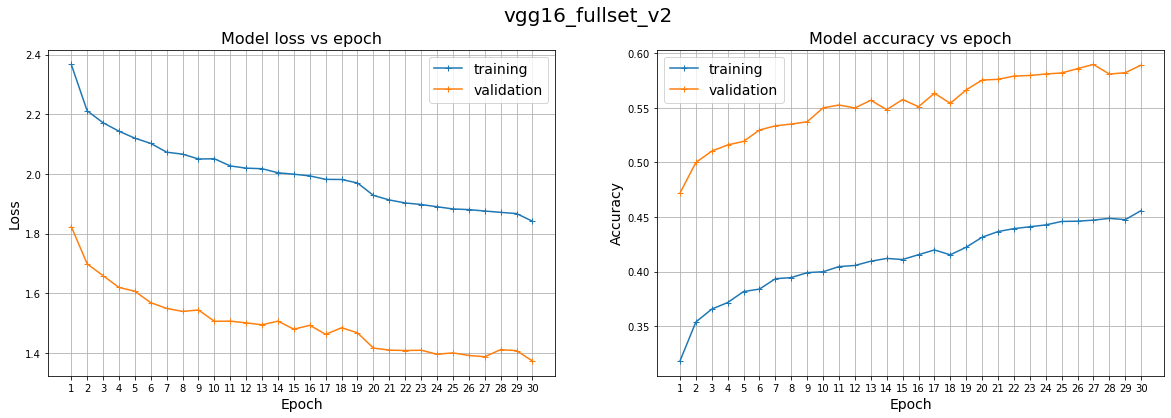

In [16]:
# --------------------------------- PARAMETERS ---------------------------------

LOAD_MODEL = True                        # fool-proofing
SAVED_MODEL_NAME = "vgg16_fullset_v2"    # /!\ name of saved model /!\
FORMAT_LOAD_H5 = True                    # set to <False> for SavedModel format
SAVED_EPOCH = None                       # see just below

# About SAVED_EPOCH
# -----------------
# 1. Set to integer i > 0 to load checkpoint, provided that epoch i was saved.
# 2. Set to <None> (or negative value) to load final model, provided training
# was successfully completed (if not try 1.).
# This parameter also affects whether history is searched as checkpoint or final
# version.

# ---------------------------------- EXECUTION ---------------------------------

if LOAD_MODEL:

    # Initialize paths (files organization should match this)
    if SAVED_EPOCH:
        PATH_MODEL_LOAD = f"./models/checkpoints/{SAVED_MODEL_NAME}_ep{SAVED_EPOCH:02d}"
        PATH_HISTORY_LOAD = f"./models/histories/{SAVED_MODEL_NAME}.csv"
    else:
        PATH_MODEL_LOAD = f"./models/{SAVED_MODEL_NAME}"
        PATH_HISTORY_LOAD = f"./models/{SAVED_MODEL_NAME}.csv"
    if FORMAT_LOAD_H5:
        PATH_MODEL_LOAD += ".h5"

    # Load model
    model = load_model(
                filepath = PATH_MODEL_LOAD,   # path to saved model
                custom_objects = None,        # only using TF built-in
                compile = True                # recompile model
                )

    # Model info
    show_model_info(model)

    # Load training history
    history = history_load(PATH_HISTORY_LOAD)
    if 'model' not in history:
        history['model'] = SAVED_MODEL_NAME     # add model name (if needed)
    complexity_graph(history)                 # plot compexity graph

At this point, performance does seems to be reaching a cap, despite learning rate reductions down to 0.0005.  

If we kept training we might see some small improvements with additional learning rate reductions, but it might also get worse.  

Anyway, this is about the performance we may expect from this model.

## Create model

In [ ]:
# --------------------------------- PARAMETERS ---------------------------------

CREATE_MODEL = False              # fool-proofing

# Architecture
PRETRAINED_MODEL = vgg16.VGG16    # /!\ pretrained model used as backbone /!\ 
DENSE_0_UNITS = 1024              # size of 1st dense layer
DENSE_1_UNITS = 512               # size of 2nd dense layer

# Training
DROP_RATE = 0.25                  # dropout rate of all dropout layers
LEARNING_RATE = 1e-2              # /!\ initial learning rate /!\ 


# ---------------------------------- EXECUTION ---------------------------------

if CREATE_MODEL:

    # Clear session (to keep layer names simple)
    tf.keras.backend.clear_session()

    # ARCHITECTURE
    # Backbone model
    backbone = PRETRAINED_MODEL(
                        include_top=False,
                        weights="imagenet"
                        )
    # /!\ Freeze weights of backbone /!\
    for layer in backbone.layers:
        layer.trainable = False
    # Instanciate model
    model = Sequential([
                backbone,
                GlobalAveragePooling2D(),
                Dense(DENSE_0_UNITS),
                BatchNormalization(),
                Activation('relu'),
                Dropout(DROP_RATE),
                Dense(DENSE_1_UNITS),
                BatchNormalization(),
                Activation('relu'),
                Dropout(DROP_RATE),
                Dense(N_CLASS),
                Activation('softmax')
                ])

    # COMPILATION
    model.compile(
            optimizer = Adam(LEARNING_RATE),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy']
            )
    
    # Model info
    show_model_info(model)

The last model created is the one which was last loaded (cf previous section).

### About model architecture

We decided to use different backbones with similar architecture, only changing number of units 1st and 2nd dense layer. The last dense layer is constrained by the number of classes.  

In later versions, we used batch normalization and dropout for regularization, and it proved to be improve model performance.  

With more time we could have tried adding additional convolutional blocks or unfreezing some of the last ones in the backbone.

### About compilation

The ADAM optimizer appears to be a solid choice these days, and we did not have enough time to make an hyperparameter of the optimizer.  

As far as we know, the categorical crossentropy loss is suitable in almost all cases, and it seemed just not worth it to try anything else here.  

As for metrics, accuracy is quite relevant here, and we decided to compute other metrics using callbacks (cf TRAINING section).

# TRAINING

## Train model

In [ ]:
# --------------------------------- PARAMETERS ---------------------------------

TRAIN_MODEL = False                      # fool-proofing

NEW_MODEL_NAME = 'vgg16_fullset_v2_it3'  # /!\ name of model (for saving) /!\
FORMAT_SAVE_H5 = True                    # set to <False> for SavedModel format
N_EPOCHS = 5                             # number of epochs for this training

# ---------------------------------- EXECUTION ---------------------------------

if TRAIN_MODEL:

    # Initialize paths (files organization should match this)
    PATH_MODEL_SAVE = f"./models/{NEW_MODEL_NAME}"
    PATH_HIST_SAVE = f"./models/{NEW_MODEL_NAME}.csv"
    PATH_CHECKPOINTS_HISTORY = f"./models/histories/{NEW_MODEL_NAME}.csv"
    PATH_CHECKPOINTS_MODEL = f"./models/checkpoints/{NEW_MODEL_NAME}" \
                            + "_ep{epoch:02d}"
    if FORMAT_SAVE_H5:
        PATH_MODEL_SAVE += ".h5"
        PATH_CHECKPOINTS_MODEL += ".h5"

    # Configure callbacks
    checkpoints = ModelCheckpoint( # save model
                    filepath = PATH_CHECKPOINTS_MODEL,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_freq = 'epoch',
                    save_weights_only = False,
                    save_best_only = True,
                    verbose = 1
                    ) 
    hist_logger = CSVLogger( # save training history     
                    filename = PATH_CHECKPOINTS_HISTORY,
                    separator = ',',
                    append = False # /!\ overwrite /!\ 
                    ) 
    plateau = ReduceLROnPlateau( # reduce LR when things stop improving
                        monitor = 'val_loss',   # most reliable criterion
                        mode = 'min',
                        patience = 2,           # stagnation tolerance
                        factor = 0.1,           # LR reduction factor on stagnation
                        min_lr = 1e-9,          # expectedly never reached 
                        verbose = 1
                        )
    stopping = EarlyStopping( # stop training if things stop improving for long
                        monitor = 'val_loss',         # most reliable criterion
                        mode = 'min',
                        patience = 5,                 # stagnation tolerance           
                        restore_best_weights = True,
                        verbose = 1
                        )
    custom_metrics = GeneratorMetrics( # compute and print custom metrics
                        validation_generator = data_flow_val,
                        average = 'weighted'          # select this over 'macro'
                        )

    # Train
    with tf.device(BESTDEV):  # explicitly activates GPU if available
        trainhist = model.fit(
                            x = data_flow_train,              # training generator
                            epochs = N_EPOCHS,
                            validation_data = data_flow_val,  # validation generator
                            batch_size = None,                # specified by generators
                            callbacks = [                     # callbacks (cf supra)
                                custom_metrics,
                                checkpoints,
                                hist_logger,
                                plateau,
                                stopping,
                                ])

    # Save model
    model.save(PATH_MODEL_SAVE)
    print(f"Model successfully saved to '{PATH_MODEL_SAVE}'")

    # Extract and save history
    history = trainhist.history                             # extract        
    history['model'] = NEW_MODEL_NAME                       # add model name
    pd.DataFrame.from_dict(history).to_csv(PATH_HIST_SAVE)  # save history as CSV
    print(f"History successfully saved to '{PATH_HIST_SAVE}'")

    # Plot complexity graph
    complexity_graph(history)

Unfortunately, the last output from this cell was reset. However it will be shown in the report.  
The model is the one which was last loaded (cf MODEL section).


## About training callbacks

The ModelCheckpoint and CSVLogger are a good way to secure training results, especially with remote execution in a platform such as as Google Colaboratory, which does not guarantee hardware access.  

The ReduceLROnPlateau is a simple, yet effective, learning rate scheduling procedure, which provides valuable adaptivity improvement, even with recent optimizers. It allowed us to set the initial learning rate to a higher value, thus speeding up training.  

The EarlyStopping callback's utility was probably shaded by ReduceLROnPlateau, but it is still a good way to avoid wasting time and computing power for nothing, without any drawback.

The GeneratorMetrics callback is a custom one inspired by [this notebook](https://gist.github.com/rragundez/ae3a17428bfec631d1b35dcdc6296a85). It allows to compute class-related metrics such as precision, recall and F1-score, on epoch end rather than batch-wise, as recommended by [this article](https://towardsdatascience.com/implementing-macro-f1-score-in-keras-what-not-to-do-e9f1aa04029d?gi=662f586be1e9).



# EVALUATION

## Try model

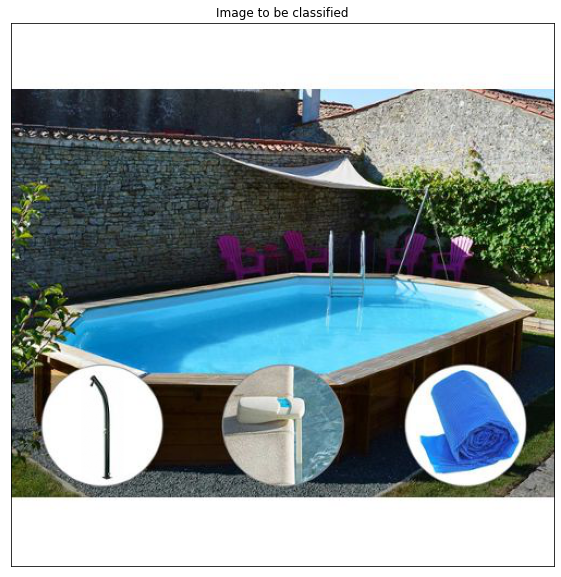

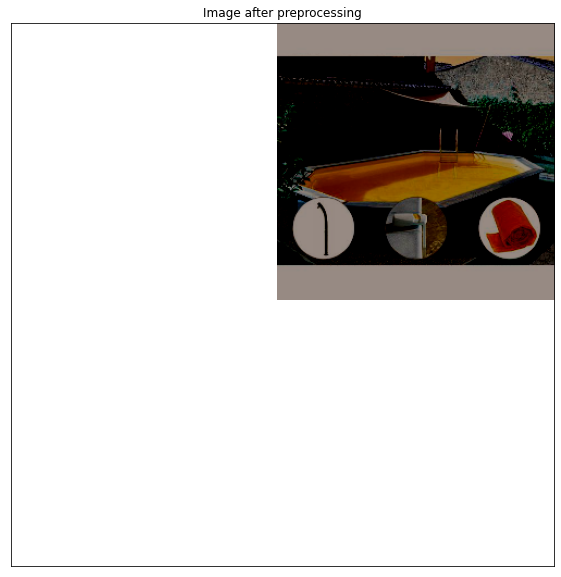

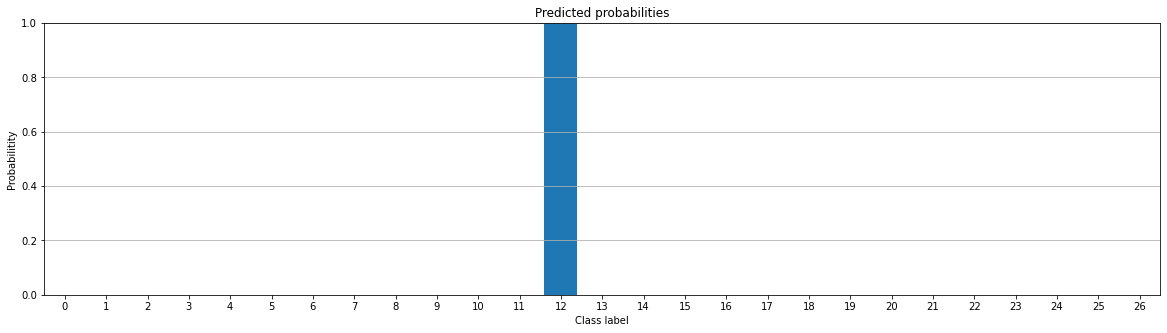

Predicted class: 12
True class: 12


In [55]:
# Load one random image
productid = 3831364117
img_bgr = cv2.imread(data_val.loc[productid, 'img_path'])
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title("Image to be classified")
plt.imshow(img_rgb/255)
plt.axis([500, 0, 500, 0])
plt.xticks([])
plt.yticks([])
plt.show();

# Preprocess
img_resz = cv2.resize(img_rgb, (256, 256))
img_prepro = vgg16.preprocess_input(img_resz)
plt.figure(figsize=(10,10))
plt.title("Image after preprocessing")
plt.imshow(np.clip(img_prepro/255, 0, 1))
plt.axis([500, 0, 500, 0])
plt.xticks([])
plt.yticks([])
plt.show();

# PREDICT
# Predict probabilities
y_probs = model.predict(np.reshape(img_prepro, (1, 256, 256, 3))).squeeze()
# Decode class indexes into labels
class_index_decoding = pd.read_csv("class_index_decoding.csv", index_col=1).sort_index().squeeze()
y_probs = [y_probs[class_index_decoding[label]] for label in range(N_CLASS)]
# Show probabilities
plt.figure(figsize=(20,5))
plt.title("Predicted probabilities")
plt.bar(range(N_CLASS), y_probs)
plt.axis([-0.5, 26.5, 0, 1])
plt.xlabel("Class label")
plt.xticks(range(N_CLASS))
plt.ylabel("Probabilitity")
plt.grid(axis='y')
plt.show();
# Decision
y_pred = np.argmax(y_probs)
# Retrieve true class label
y_true = data_val.loc[productid, 'target']

print("Predicted class:", int(y_pred))
print("True class:", int(y_true))

## Evaluate model

Predicting...
531/531 [==============================] - 127s 240ms/step
Prediction successful


>> Confusion matrix:
Model: 'vgg16_fullset_v2'


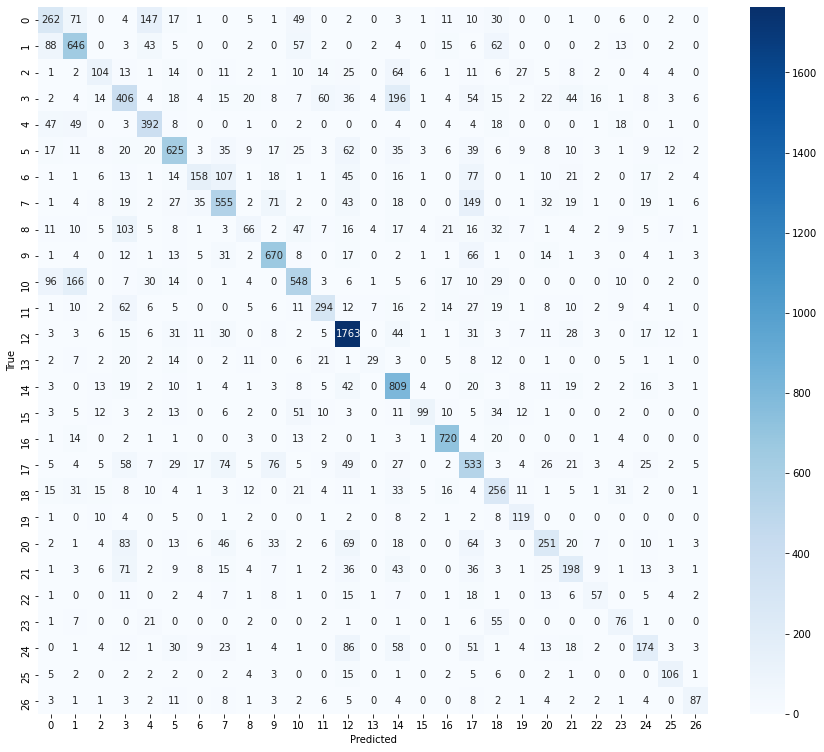


>> Notable confusions between classes (threshold=15.0%)
Class #00 was mistaken for class #04 in about 24% of occurences
Class #02 was mistaken for class #14 in about 19% of occurences
Class #03 was mistaken for class #14 in about 20% of occurences
Class #06 was mistaken for class #07 in about 21% of occurences
Class #08 was mistaken for class #03 in about 25% of occurences
Class #10 was mistaken for class #01 in about 17% of occurences
Class #15 was mistaken for class #10 in about 18% of occurences
Class #23 was mistaken for class #18 in about 32% of occurences
Class #24 was mistaken for class #12 in about 17% of occurences

>> Classification report:
Model: 'vgg16_fullset_v2'
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       623
           1       0.61      0.68      0.64       952
           2       0.46      0.31      0.37       336
           3       0.42      0.42      0.42       974
           4       0.55      0.71      0.62

In [57]:
# --------------------------------- PARAMETERS ---------------------------------

EVALUATE_MODEL = False  # fool-proofing

THRESH_RATIO = 0.15     # to detect confusion between classes (high enough)

# ---------------------------------- EXECUTION ---------------------------------

if EVALUATE_MODEL:

    # PREDICTIONS
    # Predict probability for each class index
    print("Predicting...")
    with tf.device(BESTDEV):  # explicitly activates GPU if available
        y_probs = model.predict(
                            x = data_flow_val,    # use validation generator
                            batch_size = None,    # specified by generator
                            steps = None,         # specified by generator
                            verbose = 1
                            )
    print("Prediction successful\n")

    # Decision
    classidx_pred = np.argmax(y_probs, axis=1)       # pick highest probability

    # Retrieve true class indexes
    classidx_true = np.array(data_flow_val.classes)  # extract from generator

    # Decode class indexes into labels
    labels = dict((idx, label) for (label, idx) in data_flow_val.class_indices.items())
    y_pred = pd.Series([labels[idx] for idx in classidx_pred]).astype('int')
    y_true = pd.Series([labels[idx] for idx in classidx_true]).astype('int')


    # EVALUATE & SHOW RESULTS
    # Print confusion matrix as heatmap
    confmat = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])
    print("\n>> Confusion matrix:")
    if history is not None:
        print(f"Model: '{history['model'][0]}'")
    plt.figure(figsize=(15, 13))
    sns.heatmap(data=confmat, cmap='Blues', annot=True, fmt='d')
    plt.show();

    # Detect and print notable confusions between classes
    print(f"\n>> Notable confusions between classes (threshold={THRESH_RATIO*100}%)")
    for i in range(len(confmat)):
        support_class_i = sum(confmat.iloc[i, :])
        for j in range(N_CLASS):
            error_ratio = confmat.iloc[i, j]/support_class_i
            if j != i and error_ratio > THRESH_RATIO:
                print(f"Class #{i:02d} was mistaken for class #{j:02d} in about",
                    f"{error_ratio*100:.0f}% of occurences")

    # Print classification report
    classif = classification_report(y_true, y_pred)
    print("\n>> Classification report:")
    if history is not None:
        print(f"Model: '{history['model'][0]}'")
    print(classif)

## Comments

Even though the scores are way below 100%, it is not that bad, considering the high intra-class dispersion of the images.  
That being said, the macro and weighted F1-score may even be seen as quite high.

# CONCLUSIONS

The results we obtained are consistent with, yet slightly better, than the [benchmark performance](https://challengedata.ens.fr/participants/challenges/35/) for images.  

We considered some variations of architecture and training hyperparameters, but we could not explore all of them due to lack of time and computational power. This leaves much to be explored yet.